# OLS - regression

Here we will create our baseline model. It will not contain time-dependent exogenous variables. What is more we will not focus on econometrics - BLUE assumptions!

### Dependencies loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

### Data loading

In [2]:
df = pd.read_csv("../data/train_fe.csv", index_col=0)

In [3]:
fr = pd.read_excel("../data/feature_ranking.xlsx",index_col=0)

### Feature engineering for OLS regression model

We can omit this step, because all crucial transformations like: mathematical transformations, feature creation, dummification have been already applied.

### Final feature selection for OLS regression model

#### Feature ranking

We will start with prepared in previous notebook "feature ranking". Taking into account OLS estimator properties the most important for us is output from Elastic Net (EN_coef). Let's treat this variables as our benchmark input into OLS regression model.  

In [4]:
fr.sort_values("mi_score", ascending=False).head()

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
etr_y_past,1.012573,5.678095e-85,1,0.521378,NaN,1
etr_y_ma,0.825398,9.689502e-126,1,0.527678,NaN,1
txt,0.635168,3.892292e-13,1,0.370359,0.000015,1
diff,0.633104,2.253023e-02,1,-0.291064,NaN,1
pi,0.609819,6.662031e-12,1,0.301168,0.000008,7


In [5]:
benchmark_input = fr["EN_coef"].dropna().index.tolist()

We treat year as a cont. variable!

In [6]:
benchmark_input

['rok',
 'ta',
 'txt',
 'pi',
 'xrd',
 'ni',
 'ppent',
 'intant',
 'dlc',
 'dltt',
 'capex',
 'revenue',
 'cce',
 'adv',
 'WB_GDPpc',
 'sektor_materials',
 'sektor_utilities',
 'dltt_cat_(39.38, 327.85]',
 'dltt_cat_(327.85, 876.617]',
 'dltt_cat_(876.617, inf]']

In [57]:
benchmark_input.remove("dltt")

Let's check this variables in case of high collinearity! We see that we don't deal with this problem.

In [7]:
corr = df[benchmark_input].corr("kendall")
foo = pd.DataFrame(corr.abs().unstack().sort_values(ascending=False))
foo = foo[foo[0]!=1]
foo = foo[foo.duplicated()==False]
foo.head(10)

0
pi      ni       0.833199
ta      revenue  0.782031
txt     pi       0.761797
ta      cce      0.746758
        dlc      0.721881
revenue cce      0.680492
ta      capex    0.664255
        dltt     0.663416
ni      txt      0.662137
dltt    dlc      0.642640

#### Recursive Feature Elimination 

As an econometrician I know that the best procedure in case of feature selection for OLS is general to specific approach, where we use Wald Test. But right now let's do ML - so RFE procedure seems to be good enough to create "robust" estimator. We will use RFE with CV. This CV is not the best one cause we will apply our own CV in the next chapter, but right now let's use CV implemented in scikit-learn.

In [8]:
print(df.columns.tolist())

['Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_c

We will provide all possible variables and then (after RFE) we will investigate possible collinearity!!!

In the first attempt let's create set of variables without discretization.

In [9]:
rfe_candidates = ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 
                  'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 
                  'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4',
                  'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]',
                  'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 
                  'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 
                  'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', 'capex_cat_(5451.0, inf]', 'revenue_cat_(0.174, 1248.817]', 'revenue_cat_(1248.817, 4233.587]',
                  'revenue_cat_(4233.587, inf]', 'cce_cat_(5.619, 63.321]', 'cce_cat_(63.321, inf]', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 
                  'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']

In [10]:
rfe_candidates_without_disc = [i for i in rfe_candidates if "]" not in i]

In [11]:
print(rfe_candidates_without_disc)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']


In [12]:
fr.loc[["ta","ta_log"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
ta,0.582808,1.399909e-03,1,0.268538,-1.404983e-07,45
ta_log,0.566161,4.808135e-30,1,0.268538,NaN,52


In [13]:
rfe_candidates_without_disc.remove("ta_log")

In [14]:
fr.loc[["ppent","ppent_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
ppent,0.533660,2.045675e-05,1,0.123832,-0.000001,26
ppent_sqrt,0.520167,1.267131e-09,1,0.123832,NaN,28


In [15]:
rfe_candidates_without_disc.remove("ppent_sqrt")

In [16]:
fr.loc[["intant","intant_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
intant,0.600154,1.869616e-13,1,0.297584,3.198893e-07,42
intant_sqrt,0.592554,3.495465e-25,1,0.297584,NaN,40


In [17]:
rfe_candidates_without_disc.remove("intant_sqrt")

In [18]:
fr.loc[["roa","roa_clip"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
roa,0.573598,0.000032,1,0.050612,NaN,19
roa_clip,0.574013,0.000035,1,0.050612,NaN,17


In [19]:
rfe_candidates_without_disc.remove("roa")

In [20]:
fr.loc[["lev","lev_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
lev,0.506553,0.068610,1,-0.038192,NaN,37
lev_sqrt,0.495923,0.249321,0,-0.038192,NaN,36


In [21]:
rfe_candidates_without_disc.remove("lev")

In [22]:
fr.loc[["intan","intan_pow2"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
intan,0.544500,2.255545e-07,1,0.191653,NaN,59
intan_pow2,0.531144,4.280364e-03,1,0.191653,NaN,55


In [23]:
rfe_candidates_without_disc.remove("intan")

In [24]:
fr.loc[["rd","rd_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
rd,0.089885,3.567863e-08,1,0.264235,NaN,49
rd_sqrt,0.091467,5.565075e-18,1,0.264235,NaN,43


In [25]:
rfe_candidates_without_disc.remove("rd_sqrt")

In [26]:
fr.loc[["ppe","ppe_clip"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
ppe,0.519159,8.692329e-13,1,-0.162251,NaN,30
ppe_clip,0.523710,1.118330e-12,1,-0.162251,NaN,33


In [27]:
rfe_candidates_without_disc.remove("ppe")

In [28]:
fr.loc[["cash_holdings","cash_holdings_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
cash_holdings,0.526529,0.199068,0,0.016134,NaN,46
cash_holdings_sqrt,0.529346,0.641589,0,0.016134,NaN,44


In [29]:
rfe_candidates_without_disc.remove("cash_holdings_sqrt")

In [30]:
fr.loc[["diff","diff_dta","cfc","cfc_dta"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
diff,0.633104,2.253023e-02,1,-0.291064,NaN,1
diff_dta,0.062343,8.260955e-03,1,-0.049496,NaN,16
cfc,0.124139,5.146620e-47,1,0.314395,NaN,18
cfc_dta,0.049038,6.609442e-20,1,0.205719,NaN,76


In [31]:
print(rfe_candidates_without_disc)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'rd', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'ppe_clip', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']


In [32]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5,min_features_to_select=10)
selector = selector.fit(df.loc[:,rfe_candidates_without_disc].values, df.loc[:,"etr"].values.ravel())
df.loc[:,rfe_candidates_without_disc].iloc[:,selector.support_].columns.tolist()

['str',
 'cash_holdings',
 'adv_expenditure',
 'dta',
 'y_e_p_polity',
 'gielda_2',
 'gielda_3',
 'gielda_4',
 'ni_profit_20000',
 'diff_positive',
 'cfc_dta']

In [33]:
rfe_candidates_without_disc = df.loc[:,rfe_candidates_without_disc].iloc[:,selector.support_].columns.tolist()

In [34]:
rfe_candidates = ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 
                  'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 
                  'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4',
                  'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]',
                  'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 
                  'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 
                  'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', 'capex_cat_(5451.0, inf]', 'revenue_cat_(0.174, 1248.817]', 'revenue_cat_(1248.817, 4233.587]',
                  'revenue_cat_(4233.587, inf]', 'cce_cat_(5.619, 63.321]', 'cce_cat_(63.321, inf]', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 
                  'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']

In [35]:
rfe_candidates.remove("ta_log")
rfe_candidates.remove("ppent_sqrt")
rfe_candidates.remove("intant_sqrt")
rfe_candidates.remove("roa")
rfe_candidates.remove("lev")
rfe_candidates.remove("intan")
rfe_candidates.remove("rd_sqrt")
rfe_candidates.remove("ppe")
rfe_candidates.remove("cash_holdings_sqrt")

In [36]:
print(rfe_candidates)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'rd', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28

In [37]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5,min_features_to_select=9,)
selector = selector.fit(df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel())
print(df.loc[:,rfe_candidates].iloc[:,selector.support_].columns.tolist())
rfe_candidates = df.loc[:,rfe_candidates].iloc[:,selector.support_].columns.tolist()

['str', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]']


Now we have 3 sets of candidates!

Let's investigate permutation importance of such candidates!

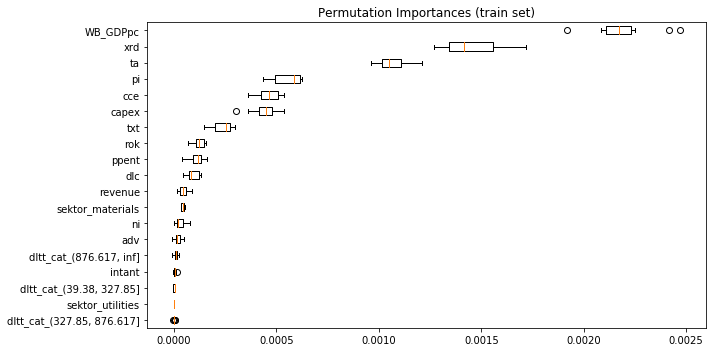

In [58]:
estimator = LinearRegression()
estimator.fit(df.loc[:,benchmark_input].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,benchmark_input].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,benchmark_input].columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

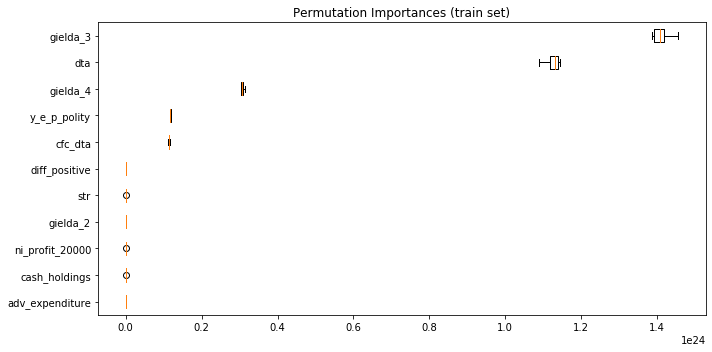

In [56]:
estimator = LinearRegression()
estimator.fit(df.loc[:,rfe_candidates_without_disc].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,rfe_candidates_without_disc].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,rfe_candidates_without_disc].columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

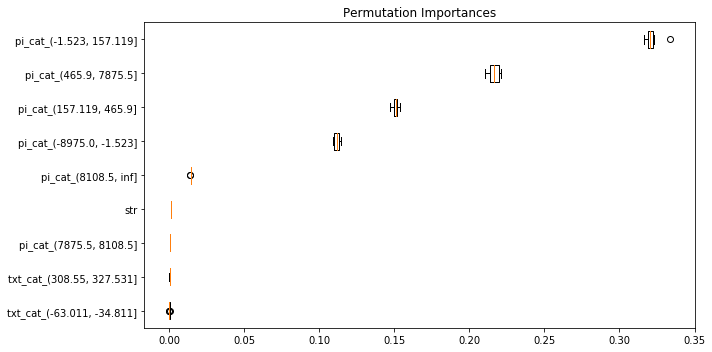

In [53]:
estimator = LinearRegression()
estimator.fit(df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,rfe_candidates].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

As we expect the most reasonable is set of variables from ElasticNet!

Let's try something new for us - permutation importance for feature selection.

In [59]:
rfe_candidates = ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 
                  'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 
                  'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4',
                  'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]',
                  'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 
                  'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 
                  'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', 'capex_cat_(5451.0, inf]', 'revenue_cat_(0.174, 1248.817]', 'revenue_cat_(1248.817, 4233.587]',
                  'revenue_cat_(4233.587, inf]', 'cce_cat_(5.619, 63.321]', 'cce_cat_(63.321, inf]', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 
                  'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']

In [91]:
estimator = LinearRegression()
estimator.fit(df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [92]:
sorted_idx = sorted_idx[-20:]

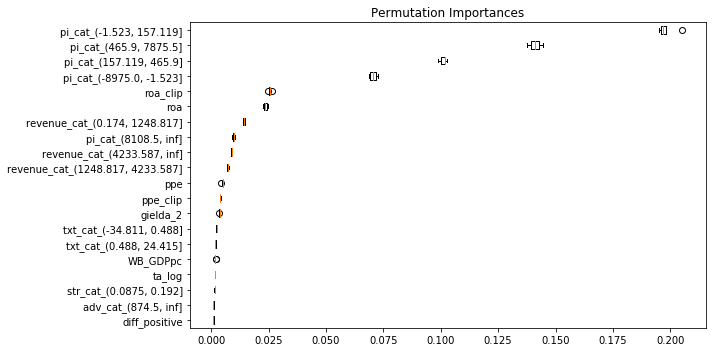

In [93]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,rfe_candidates].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [97]:
pi_var = df.loc[:,rfe_candidates].columns[sorted_idx].tolist()
pi_var.remove("roa")

In [107]:
estimator = LinearRegression()
estimator.fit(df.loc[:,pi_var].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,pi_var].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [108]:
sorted_idx = sorted_idx[-9:]

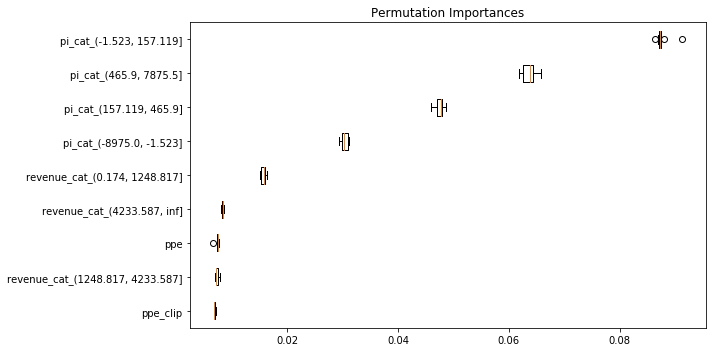

In [109]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,pi_var].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

### Models performance in a proper CV

We would like to fight against data leakage in our CV, so we will treat it like a panel problem with a rolling window. We now based on our experience that this kind of approach is crucial to fight against overfitting.

Sliding window:
 * T: 2005 - 2008; V: 2009
 * T: 2005 - 2009; V: 2010
 * T: 2005 - 2010; V: 2011
 * ...

In [124]:
df = df.sort_values(by="rok").reset_index(drop=True)

In [276]:
def proper_CV(x, y, model):
    train_score = list()
    valid_score = list()
    train_indexes = [0, 1452]
    valid_indexes = [1452, 1815]
    for i in range(0,6):
        train_x =  x[x.index.isin(range(train_indexes[0],train_indexes[1]))]
        train_y =  y[y.index.isin(range(train_indexes[0],train_indexes[1]))]
        valid_x =  x[x.index.isin(range(valid_indexes[0],valid_indexes[1]))]
        valid_y =  y[y.index.isin(range(valid_indexes[0],valid_indexes[1]))]

        model.fit(train_x.values, train_y.values)
        
        
        train_indexes = [0, valid_indexes[1]]
        valid_indexes = [train_indexes[1], valid_indexes[1]+363]


In [278]:
# .ravel()

In [277]:
proper_CV(df.loc[:,pi_var], df.loc[:,"etr"])

(363, 19)
(363, 19)
(363, 19)
(363, 19)
(363, 19)
(363, 19)


In [271]:
df[df.index.isin(range(0,1452))]

,Ticker,Nazwa2,rok,ta,txt,pi,str,xrd,ni,ppent,intant,dlc,dltt,capex,revenue,cce,adv,etr,diff,roa,lev,intan,rd,ppe,sale,cash_holdings,adv_expenditure,capex2,cfc,dta,capex2_scaled,y_v2x_polyarchy,y_e_p_polity,y_BR_Democracy,WB_GDPgrowth,WB_GDPpc,WB_Inflation,rr_per_country,rr_per_sector,sektor_consumer discretionary,sektor_consumer staples,sektor_energy,sektor_health care,sektor_industrials,sektor_materials,sektor_real estate,sektor_technology,sektor_utilities,gielda_2,gielda_3,gielda_4,gielda_5,ta_log,"txt_cat_(-63.011, -34.811]","txt_cat_(-34.811, 0.488]","txt_cat_(0.488, 24.415]","txt_cat_(24.415, 25.05]","txt_cat_(25.05, 308.55]","txt_cat_(308.55, 327.531]","txt_cat_(327.531, inf]","pi_cat_(-8975.0, -1.523]","pi_cat_(-1.523, 157.119]","pi_cat_(157.119, 465.9]","pi_cat_(465.9, 7875.5]","pi_cat_(7875.5, 8108.5]","pi_cat_(8108.5, inf]","str_cat_(0.0875, 0.192]","str_cat_(0.192, 0.28]","str_cat_(0.28, inf]",xrd_exists,ni_profit,ni_profit_20000,ppent_sqrt,intant_sqrt,"dlc_cat_(42.262, 176.129]","dlc_cat_(176.129, 200.9]","dlc_cat_(200.9, inf]","dltt_cat_(39.38, 327.85]","dltt_cat_(327.85, 876.617]","dltt_cat_(876.617, inf]","capex_cat_(7.447, 79.55]","capex_cat_(79.55, 5451.0]","capex_cat_(5451.0, inf]","revenue_cat_(0.174, 1248.817]","revenue_cat_(1248.817, 4233.587]","revenue_cat_(4233.587, inf]","cce_cat_(5.619, 63.321]","cce_cat_(63.321, inf]","adv_cat_(0.3, 874.5]","adv_cat_(874.5, inf]",diff_positive,roa_clip,lev_sqrt,intan_pow2,rd_sqrt,ppe_clip,cash_holdings_sqrt,adv_expenditure_positive,diff_dta,cfc_dta,etr_y_past,etr_y_ma,diff_ma,roa_ma,lev_ma,intan_ma,ppe_ma,sale_ma,cash_holdings_ma,roa_past,lev_past,intan_past,ppe_past,sale_past,cash_holdings_past
0,11B PW Equity,11 bit studios SA,2005,21.127613,1.241850,6.329725,0.190000,0.0,5.087900,0.276275,4.195900,0.000000,0.000000,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.000000,0.198598,0.000000,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.877,10,1,3.493668,8021.003655,2.183799,0.334868,0.030010,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.048390,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.000000,3.944113e-02,0.000000,0.013076,0.758119,0,-0.000000,0,0.196193,0.196193,-0.006193,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744
1,ATD PW Equity,Atende SA,2005,138.925095,1.961700,9.016100,0.190000,0.0,6.804700,20.369900,19.464001,5.362800,5.919801,6.149000,185.603394,21.661600,0.0,0.217577,-0.027577,0.048981,0.081214,0.140104,0.000000,0.146625,0.848438,0.155923,0.0,0.301867,0,0,0.000280,0.877,10,1,3.493668,8021.003655,2.183799,0.334868,0.003823,0,0,0,0,0,0,0,1,0,0,0,0,0,4.933935,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,4.513303,4.411802,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.048981,0.284980,1.962921e-02,0.000000,0.146625,0.394871,0,-0.000000,0,0.217577,0.217577,-0.027577,0.048981,0.081214,0.140104,0.146625,0.848438,0.155923,0.048981,0.081214,0.140104,0.146625,0.848438,0.155923
2,ULM PW Equity,Ulma Construccion Polska SA,2005,155.968002,4.110000,22.291000,0.190000,0.0,18.181000,113.878998,0.765000,16.125000,43.176998,55.081001,98.593002,1.442000,0.0,0.198091,0.005621,0.116569,0.380219,0.004905,0.000000,0.730143,0.489890,0.009245,0.0,0.483680,0,0,0.000449,0.877,10,1,3.493668,8021.003655,2.183799,0.334868,0.003557,0,0,0,0,1,0,0,0,0,0,0,0,0,5.049651,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,10.671410,0.874643,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0.116569,0.616619,2.405757e-05,0.000000,0.730143,0.096153,0,0.000000,0,0.198091,0.189586,-0.001235,0.125949,0.410959,0.004220,0.736444,0.490449,0.009248,0.116569,0.380219,0.004905,0.730143,0.489890,0.009245
3,FIE GY Equity,Fielmann AG,2005,501.535004,29.260000,87.015999,0.307000,0.0,55.044998,189.304001,46.698002,22.329000,4.216000,50.444000,733.073975,81.870003,0.0,0.328590,-0.029260,0.109753,0.052928,0.093110,0.000000,0.377449,0.900836,0.163239,0.0,0.266471,1,0,0.000247,0.865,10,1,3.179729,42030.286610,2.089136,0.165145,-0.073539

### Fit final model and save it